# Grad-CAM Implementation - XAI Project

### Introduction

In the rapidly evolving field of artificial intelligence, we often encounter models that are considered **"black boxes"** due to their complex internal mechanisms. While these models can produce highly accurate predictions, understanding the reasoning behind these predictions remains a challenge. This project aims to address this issue in the context of brain tumor image classification.

### Project Overview

In this project, we will be developing a **Convolutional Neural Network (CNN)** that can accurately classify brain tumor images. We will be utilizing three state-of-the-art pre-trained models:

1. **VGG16**
2. **ResNet50**
3. **DenseNet121**

These models have been selected due to their exceptional performance in image classification tasks. By using these pre-trained models, we can leverage their learned feature representations, thereby saving significant computational resources and time.


#### **Explainability**

To demystify our models, we will be employing **Grad-CAM (Gradient-weighted Class Activation Mapping)**. Grad-CAM uses the gradients of any target concept, flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept.

### Importance of the Project

- The project has the potential to contribute significantly to the field of **medical imaging and diagnosis**.
  
- **Brain tumor** are a serious health concern, and early detection can lead to improved patient outcomes.

- The development of a model that can accurately classify brain tumor images and explain its predictions can provide valuable insights to healthcare professionals.

- This could potentially lead to **more accurate diagnoses** and a better understanding of these complex diseases.

- The use of explainable AI in this project highlights the importance of **transparency and interpretability** in machine learning models.

- As AI continues to advance in various fields, it becomes increasingly crucial to ensure that these models are understandable and justifiable.

### Load necessary libraries

In [9]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Layer, Flatten
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

## Classes
- The name of the classes of pokemons used in the dataset

In [2]:
class_names = pd.DataFrame(os.listdir('./brain tumor/Training'), columns = ['Brain Tumors'])
class_names

Brain Tumors
0       glioma
1   meningioma
2      notumor
3    pituitary

## Data Generator

In [3]:
batch_size = 32
img_size = 224

datagen = ImageDataGenerator(rescale=1/255.,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest',
                             validation_split=0.15)

train_generator = datagen.flow_from_directory('./brain tumor/Training',  
                                                target_size=(img_size, img_size), 
                                                batch_size=batch_size,
                                                shuffle=True,
                                                class_mode='categorical',
                                                subset='training')  

validation_generator = datagen.flow_from_directory('./brain tumor/Training',  
                                                target_size=(img_size, img_size), 
                                                batch_size=batch_size,
                                                shuffle=True,
                                                class_mode='categorical',
                                                subset='validation')  

test_generator = datagen.flow_from_directory('./brain tumor/Testing',
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    class_mode='categorical')

Found 4413 images belonging to 4 classes.
Found 777 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


### Pre-trained DenseNet121
* Finetune the entire network
* Imagenet contains various images, so the network has already learnt features related to other images
* Keep the learning rate as small as possible because the new trained weights should be close the weights previously learnt to identify features of this use case

### Custom Model Structure

1. **Base Model (DenseNet121)**:
   - We initialize the DenseNet121 model with pre-trained weights from ImageNet. We exclude the top layers (fully connected layers) as we will be adding our own. The input shape is set to the size of our images.

2. **Adding Custom Layers**:
   - We add our own layers on top of the base model. We use the output from the last layer of the base model and add a **Batch Normalization** layer. This is followed by a **Global Average Pooling 2D** layer. Then, we add a **Dense layer with 256 neurons**, **‘relu’** activation function, and **various regularizers**. After that, we add a **Dropout layer** with a rate of **0.45**. The final layer is a **Dense layer with 4 neurons** (corresponding to our 4 classes) and **‘softmax’** activation function.

3. **Optimizer**:
   - Adam Optimizer, adjusts the learning rate adaptively for each parameter.

4. **Learning Rate**:
   - 0.0001, slow and steady

### Model Definition and Hyperparameter Settings

In [25]:
# Define the base model
base_model = DenseNet121(include_top=False,
                      weights='imagenet',
                      input_shape=(img_size, img_size, 3))

# Keep the pre-trained layers frozen
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
last = base_model.layers[-1].output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(last)
x = GlobalAveragePooling2D()(x)
x = Dense(256, kernel_regularizer=regularizers.l2(0.016), 
               activity_regularizer=regularizers.l1(0.006), 
               bias_regularizer=regularizers.l1(0.006), 
               activation='relu')(x)
x = Dropout(rate= 0.45, seed=123)(x)
x = Dense(4, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=x)

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics= ['accuracy'])

# Print the model summary
model.summary()

29084464/29084464 [==============================] - 31s 1us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_14[0][0]']               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                          

### Model Checkpoints
- Reduce the learning rate if the validation loss does not decrease after 3 successive epochs
- Stop the training if the validation loss does not decrease after 5 successive epochs
- Save the best model if it has a better validation loss than before

In [26]:
model_name = "brain tumor 4.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=0)

earlystopping = EarlyStopping(monitor='val_loss', 
                              min_delta = 0, 
                              patience = 5, 
                              verbose = 1, 
                              restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', 
                                            patience = 3, 
                                            verbose = 1, 
                                            factor = 0.2, 
                                            min_lr = 0.00000001)

### Model Training

In [27]:
history = model.fit(train_generator,
                    epochs = 15,
                    batch_size = 1,
                    validation_data = validation_generator,
                    callbacks = [checkpoint, earlystopping, learning_rate_reduction])

Epoch 1/15
138/138 [==============================] - 69s 463ms/step - loss: 3.7615 - accuracy: 0.8040 - val_loss: 2.3360 - val_accuracy: 0.7838 - lr: 0.0010
Epoch 2/15
138/138 [==============================] - 54s 387ms/step - loss: 1.6646 - accuracy: 0.8785 - val_loss: 1.4391 - val_accuracy: 0.8069 - lr: 0.0010
Epoch 3/15
138/138 [==============================] - 53s 383ms/step - loss: 1.0907 - accuracy: 0.8810 - val_loss: 1.0726 - val_accuracy: 0.8018 - lr: 0.0010
Epoch 4/15
138/138 [==============================] - 54s 389ms/step - loss: 0.8297 - accuracy: 0.8842 - val_loss: 0.8725 - val_accuracy: 0.8224 - lr: 0.0010
Epoch 5/15
138/138 [==============================] - 54s 390ms/step - loss: 0.6814 - accuracy: 0.8992 - val_loss: 0.7499 - val_accuracy: 0.8468 - lr: 0.0010
Epoch 6/15
138/138 [==============================] - 55s 394ms/step - loss: 0.6114 - accuracy: 0.8971 - val_loss: 0.6986 - val_accuracy: 0.8404 - lr: 0.0010
Epoch 7/15
138/138 [==============================] 

### Learning Curves

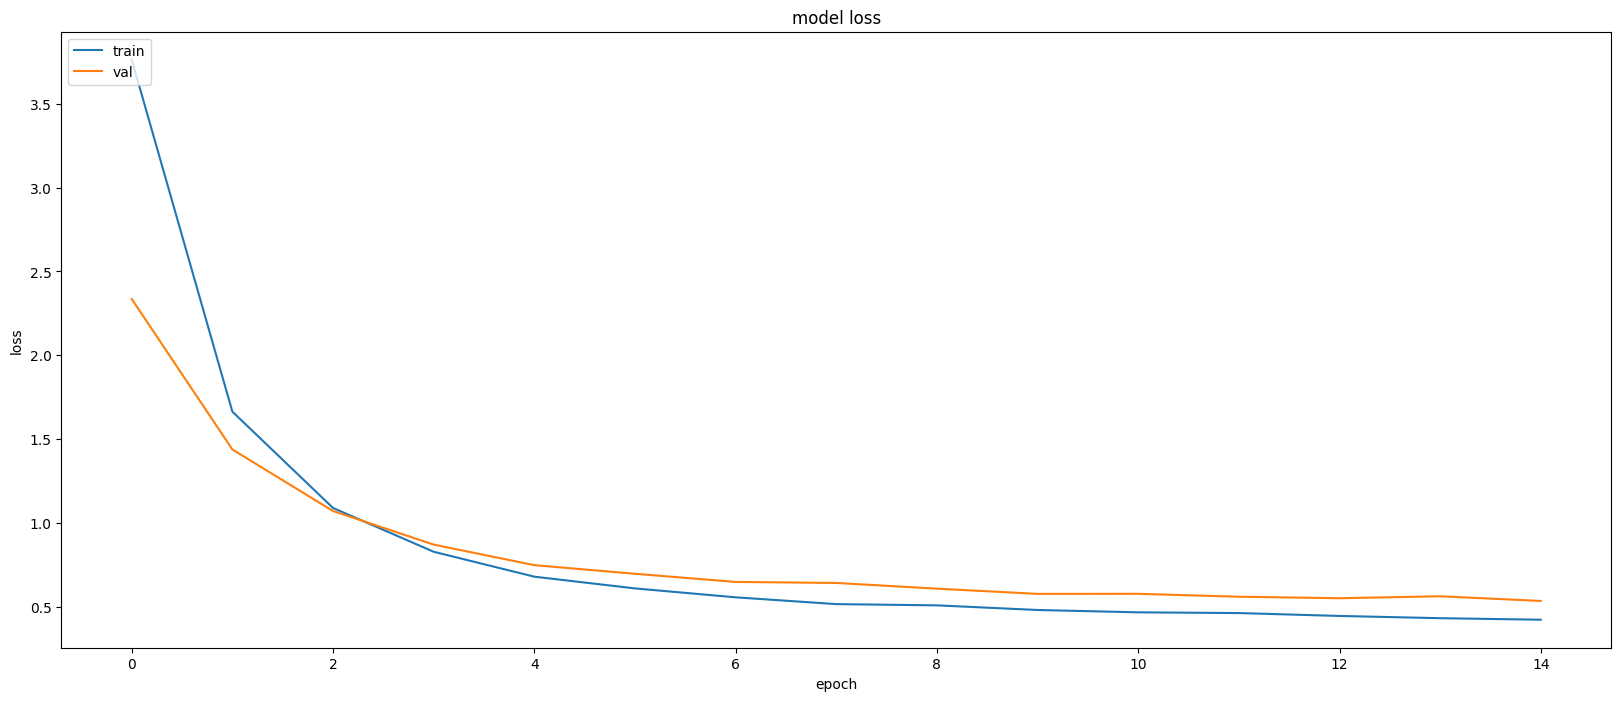

In [28]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

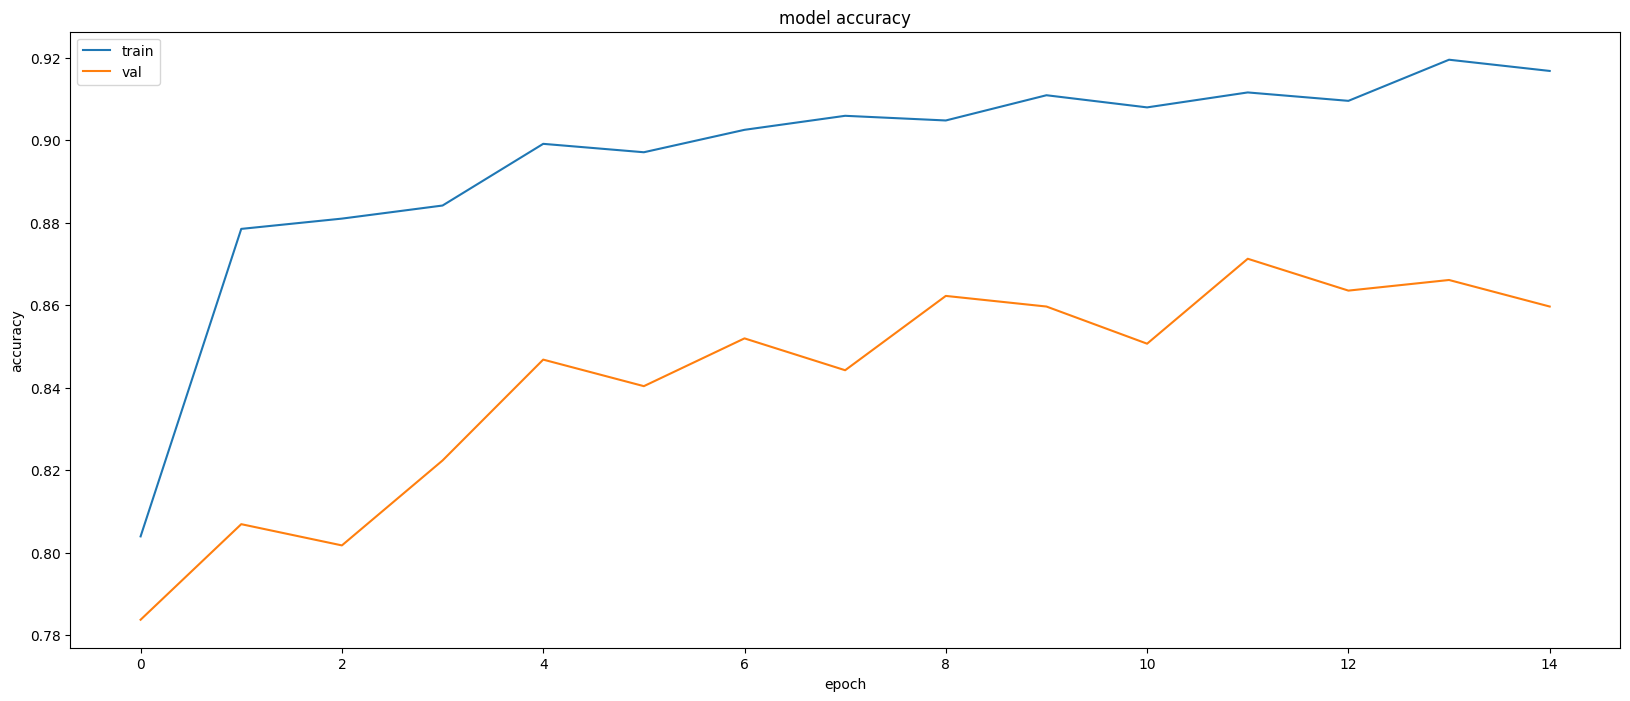

In [29]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Save model

In [67]:
model.save('brain tumor DenseNet121.h5')

#### Load model

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('brain tumor DenseNet121.h5')

### Model Evalutation

In [30]:
from sklearn.metrics import classification_report

In [49]:
y_val = test_generator.classes
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

41/41 [==============================] - 17s 393ms/step


### Classification Report

In [50]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87       300
           1       0.79      0.86      0.82       306
           2       0.95      0.95      0.95       405
           3       0.91      0.95      0.93       300

    accuracy                           0.90      1311
   macro avg       0.90      0.89      0.89      1311
weighted avg       0.90      0.90      0.90      1311



### Check using tables

In [51]:
class_indices = test_generator.class_indices
indices = {v:k for k,v in class_indices.items()}

In [52]:
filenames = test_generator.filenames

In [53]:
val_df = pd.DataFrame()
val_df['filename'] = filenames
val_df['actual'] = y_val
val_df['predicted'] = y_pred
val_df['actual'] = val_df['actual'].apply(lambda x: indices[x])
val_df['predicted'] = val_df['predicted'].apply(lambda x: indices[x])
val_df.loc[val_df['actual']==val_df['predicted'],'Same'] = True
val_df.loc[val_df['actual']!=val_df['predicted'],'Same'] = False
val_df.head(30)

filename  actual   predicted   Same
0   glioma\Te-glTr_0000.jpg  glioma      glioma   True
1   glioma\Te-glTr_0001.jpg  glioma      glioma   True
2   glioma\Te-glTr_0002.jpg  glioma      glioma   True
3   glioma\Te-glTr_0003.jpg  glioma      glioma   True
4   glioma\Te-glTr_0004.jpg  glioma      glioma   True
5   glioma\Te-glTr_0005.jpg  glioma      glioma   True
6   glioma\Te-glTr_0006.jpg  glioma      glioma   True
7   glioma\Te-glTr_0007.jpg  glioma      glioma   True
8   glioma\Te-glTr_0008.jpg  glioma      glioma   True
9   glioma\Te-glTr_0009.jpg  glioma      glioma   True
10    glioma\Te-gl_0010.jpg  glioma      glioma   True
11    glioma\Te-gl_0011.jpg  glioma      glioma   True
12    glioma\Te-gl_0012.jpg  glioma      glioma   True
13    glioma\Te-gl_0013.jpg  glioma      glioma   True
14    glioma\Te-gl_0014.jpg  glioma      glioma   True
15    glioma\Te-gl_0015.jpg  glioma      glioma   True
16    glioma\Te-gl_0016.jpg  glioma      glioma   True
17    glioma\Te-gl_0017.jpg  glioma      glioma   True
18    glioma\Te-gl_0018.jpg  glioma      glioma   True
19    glioma\Te-gl_0019.jpg  glioma  meningioma  False
20    glioma\Te-gl_0020.jpg  glioma      glioma   True
21    glioma\Te-gl_0021.jpg  glioma      glioma   True
22    glioma\Te-gl_0022.jpg  glioma      glioma   True
23    glioma\Te-gl_0023.jpg  glioma      glioma   True
24    glioma\Te-gl_0024.jpg  glioma      glioma   True
25    glioma\Te-gl_0025.jpg  glioma      glioma   True
26    glioma\Te-gl_0026.jpg  glioma      glioma   True
27    glioma\Te-gl_0027.jpg  glioma      glioma   True
28    glioma\Te-gl_0028.jpg  glioma  meningioma  False
29    glioma\Te-gl_0029.jpg  glioma      glioma   True

In [54]:
val_df = val_df.sample(frac=1).reset_index(drop=True)

## Grad-CAM

"Gradient-weighted Class Activation Mapping (Grad-CAM), uses the gradients of any target concept (say 'dog' in a classification network or a sequence of words in captioning network) flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept." **- Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization** (Ramprasaath R. Selvaraju, Michael Cogswell, Abhishek Das, Ramakrishna Vedantam, Devi Parikh, Dhruv Batra)

- Derivative of the class with the highest probability returned by the softmax layer is taken with respect to the final convolutional layer to produce a heat map which highlights the important regions in the image that activated the class.
- For full mathematical details please check out this paper: https://arxiv.org/abs/1610.02391

### Image Visualization
- Correctly Classified (A and P are same)
- Misclassified (A and P are different)
- A: Actual P: Predicted

In [55]:
def readImage(path):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = readImage(f"./brain tumor/Testing/{temp_df.filename[i]}")
        plt.imshow(image)
        plt.title(f'A: {temp_df.actual[i]} P: {temp_df.predicted[i]}')

### Correctly Classified

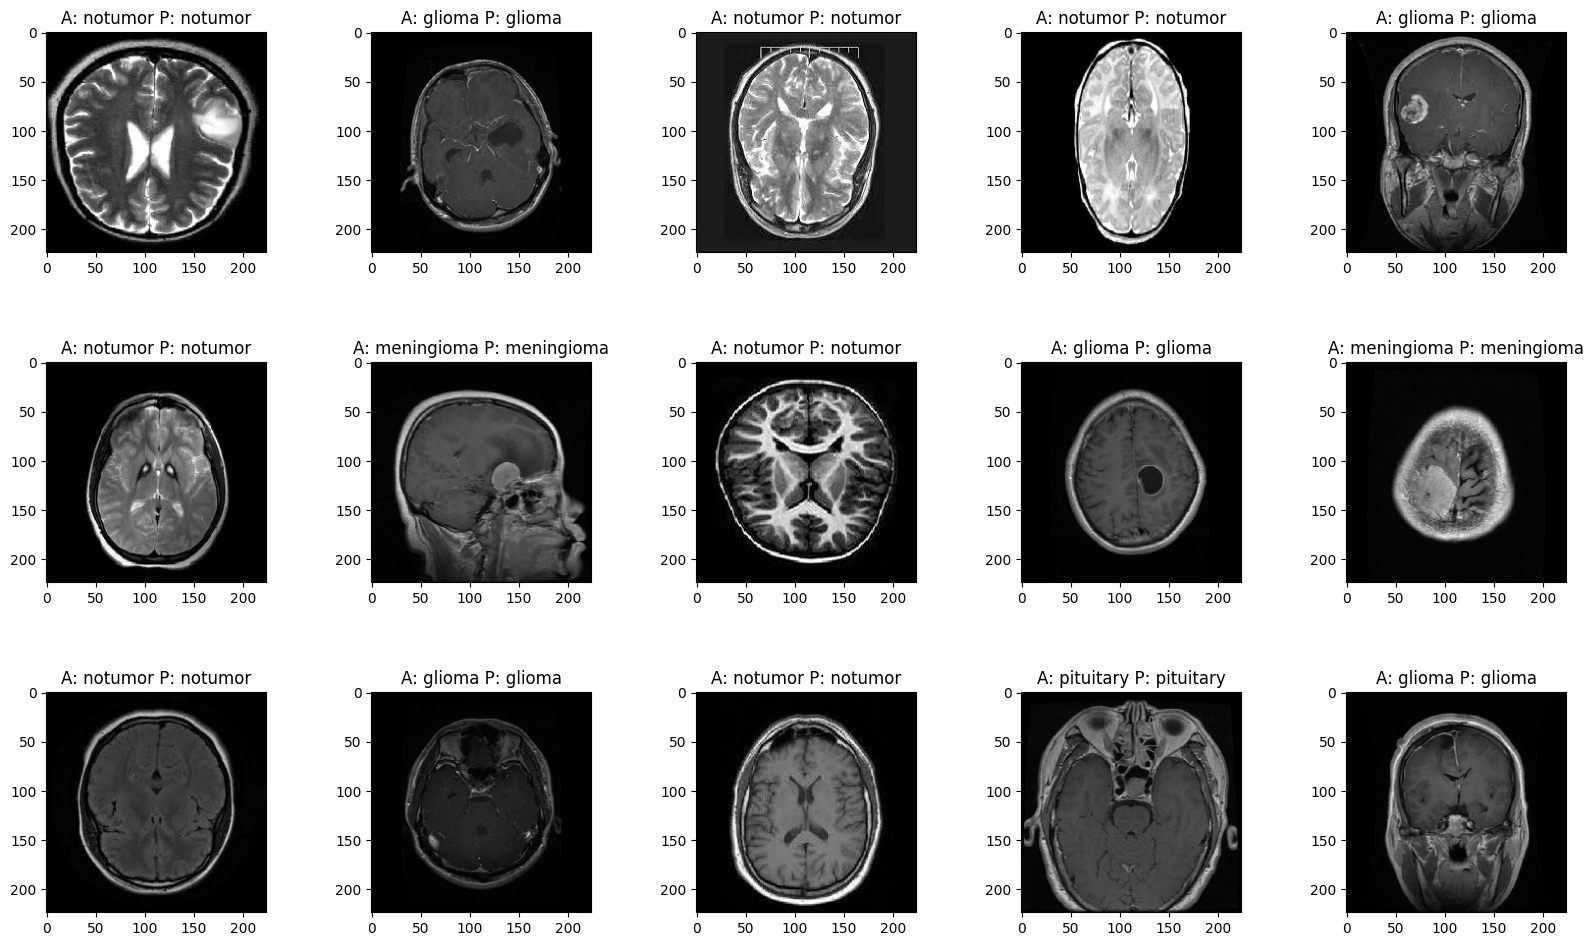

In [56]:
display_images(val_df[val_df['Same']==True])

### Misclassified

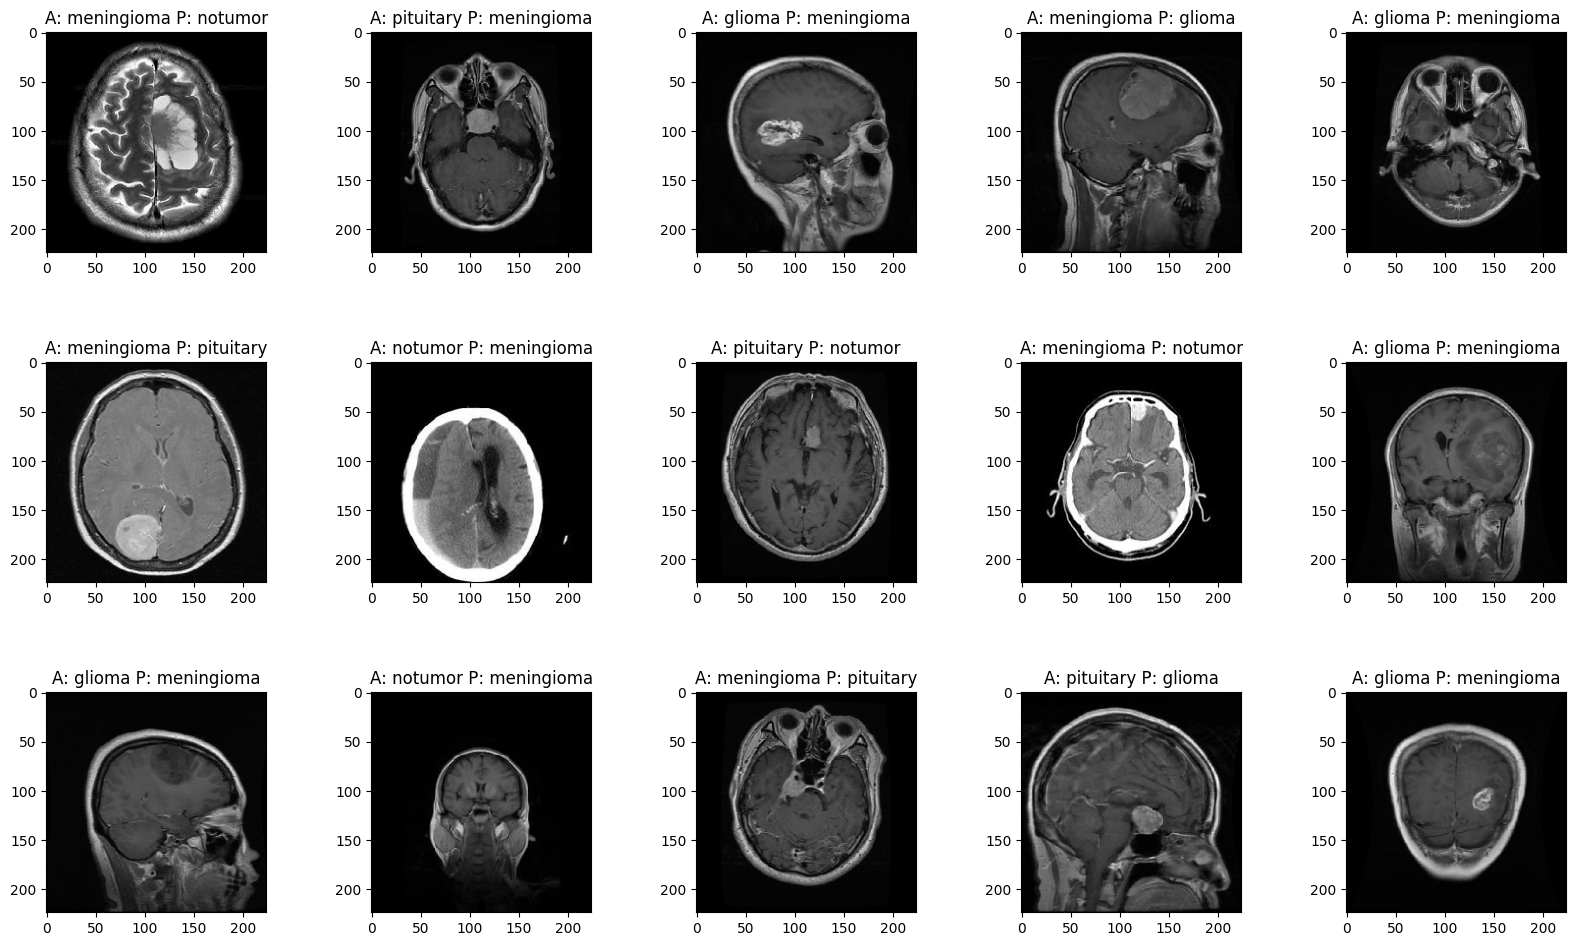

In [57]:
display_images(val_df[val_df['Same']!=True])

### Grad-CAM Computation
- Gradient computed of the final softmax layer with respect to the last convolution layer
- The fourth last layer of our model is the final convolutional block in our VGG-16 finetuned architecture
- Mean of the gradients is then multiplied to the last convolution layer's output 
- The output is then passed through a relu function to ensure that all values are positive

In [58]:
def make_gradcam_heatmap(img_array, model, pred_index=None):
    
    grad_model = Model(inputs=model.inputs, outputs=[model.layers[-8].output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), preds

In [59]:
import matplotlib.cm as cm

In [60]:
val_df

filename      actual   predicted  Same
0        notumor\Te-no_0287.jpg     notumor     notumor  True
1       glioma\Te-glTr_0008.jpg      glioma      glioma  True
2        notumor\Te-no_0264.jpg     notumor     notumor  True
3        notumor\Te-no_0181.jpg     notumor     notumor  True
4         glioma\Te-gl_0036.jpg      glioma      glioma  True
...                         ...         ...         ...   ...
1306  meningioma\Te-me_0101.jpg  meningioma  meningioma  True
1307   notumor\Te-noTr_0005.jpg     notumor     notumor  True
1308      glioma\Te-gl_0162.jpg      glioma      glioma  True
1309  meningioma\Te-me_0038.jpg  meningioma  meningioma  True
1310     notumor\Te-no_0364.jpg     notumor     notumor  True

[1311 rows x 4 columns]

# Grad-CAM Implementation
* Understand which part of your images play a role in the final activation of a class
* Project the important spatial features of your input images and analyse what can be changed to improve the classifier's performance

### Grad-CAM Projection
- The heatmap produced using the Grad-CAM computation is then projected on to the original image
- The heatmap highlights the important parts of the image that lead to the activation of a class in the final softmax layer

In [61]:
def gradCAMImage(image):
    path = f"./brain tumor/Testing/{image}"
    img = readImage(path)
    img = np.expand_dims(img,axis=0)
    heatmap,preds = make_gradcam_heatmap(img,model)

    img = load_img(path)
    img = img_to_array(img)
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.8 + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    
    return superimposed_img

## Results

In [62]:
def gradcam_of_images(correct_class):
    grad_images = []
    title = []
    temp_df = val_df[val_df['Same']==correct_class]
    temp_df = temp_df.reset_index(drop=True)
    for i in range(15):
        image = temp_df.filename[i]
        grad_image = gradCAMImage(image)
        grad_images.append(grad_image)
        title.append(f"A: {temp_df.actual[i]} P: {temp_df.predicted[i]}")

    return grad_images, title

In [ ]:
correctly_classified, c_titles = gradcam_of_images(correct_class=True)
misclassified, m_titles = gradcam_of_images(correct_class=False)

In [64]:
def display_heatmaps(classified_images,titles):
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        plt.imshow(classified_images[i])
        plt.title(titles[i])
    plt.show()

### Grad-CAM: Correctly Classified

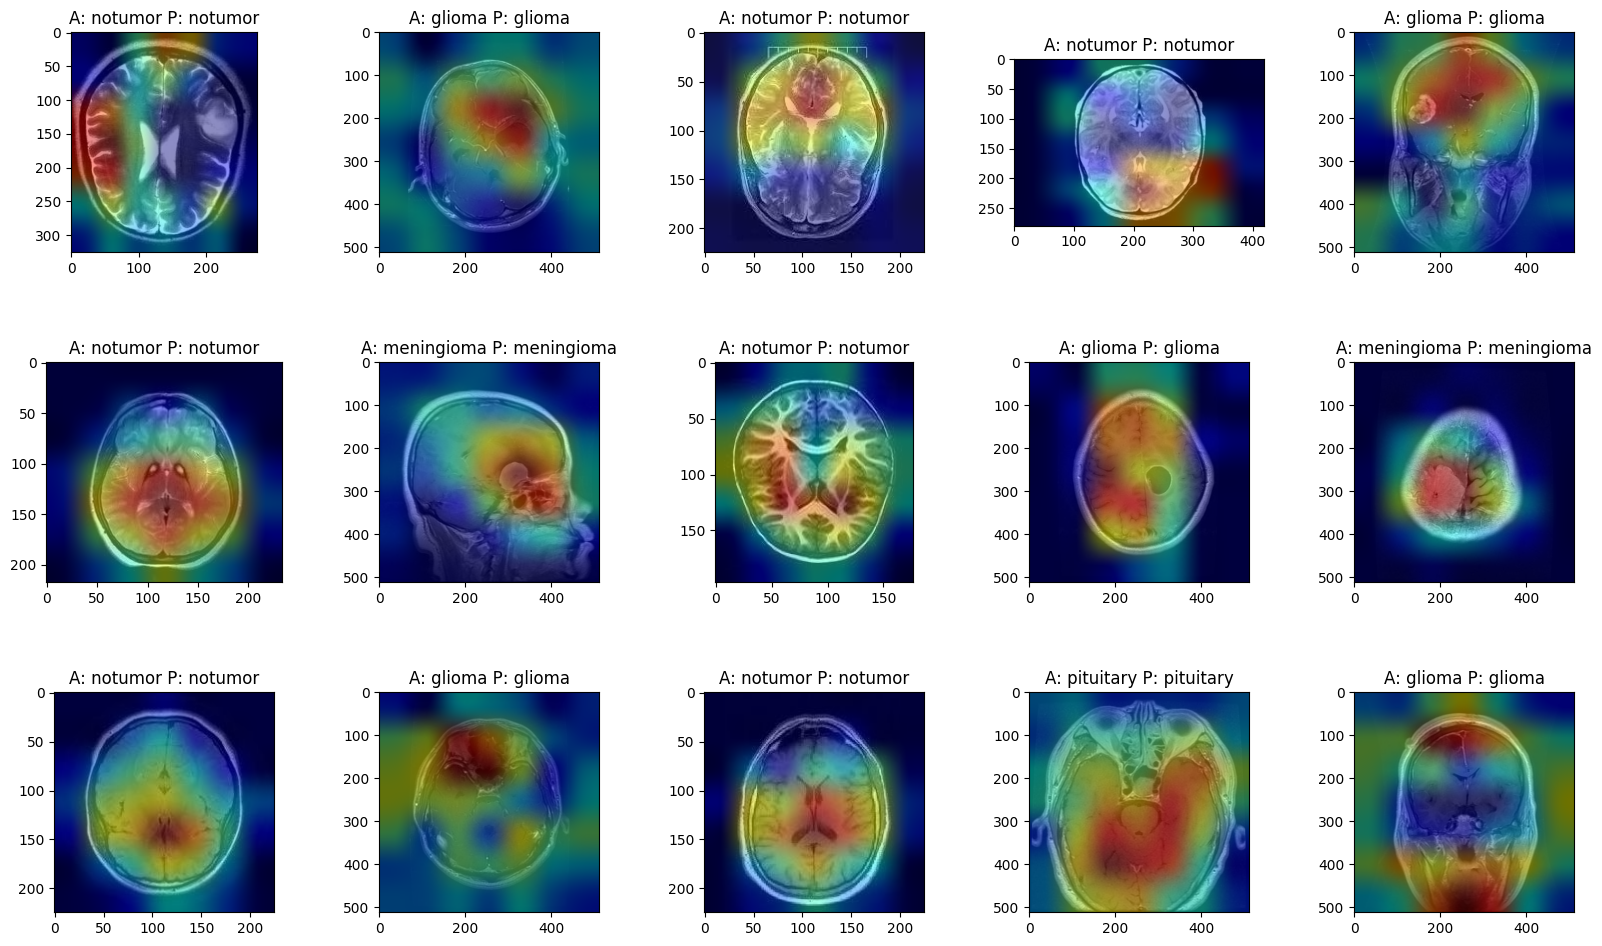

In [65]:
display_heatmaps(correctly_classified,c_titles)

**Inference:** As it can be seen some important features of the brain are highlighted in the image
- Pituitary Gland
- Meninges
- Glial cells position
- Checks alomst entire brain if there is not tumor

### Grad-CAM: Incorrectly Classified

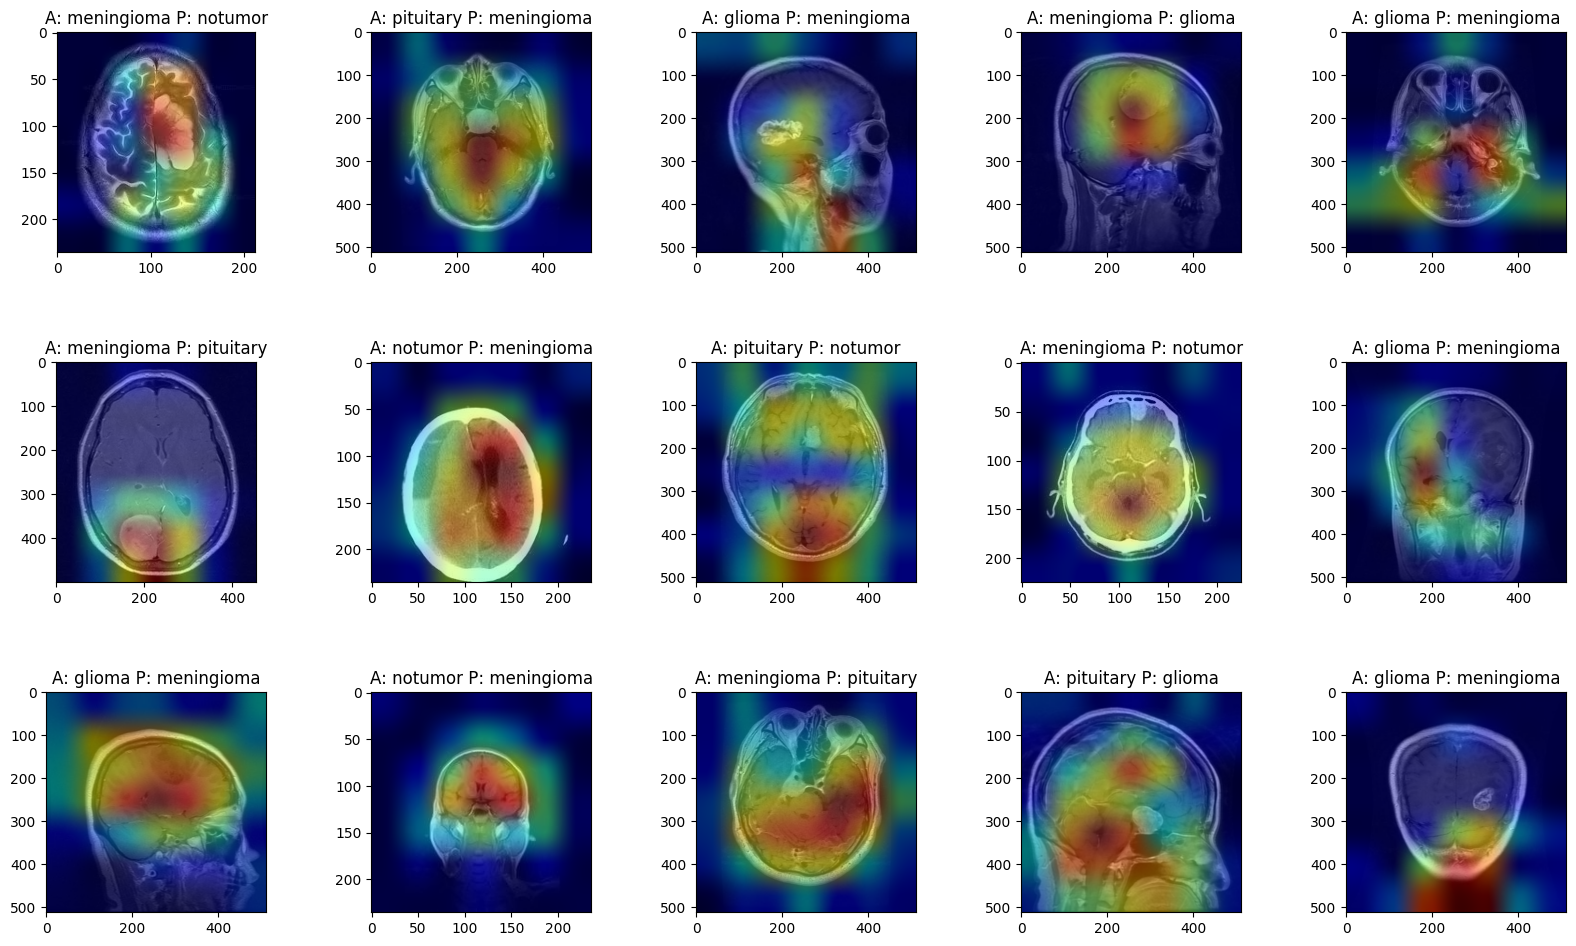

In [66]:
display_heatmaps(misclassified,m_titles)

**Inference:** As it can be seen some features have been incorrectly detected on some of these brain pictures either due to bad understanding of the struture:

- Sometimes problem with Meningioma and Pituitary
- Little work needs to be done for Meningioma and Glioma

These challenges can be resolved by changing the augmentation pipeline and getting more different types of images.

## Conclusion

This project on Explainable AI for Brain Tumor Image Classification has been a fascinating journey. We have not only built models that can accurately classify brain tumor images but also delved into the reasoning behind these classifications.

We used three different pre-trained models: **VGG16**, **ResNet50**, and **DenseNet121**. Each of these models brought their unique strengths to the table. However, **DenseNet121** outperformed the others, achieving an impressive accuracy of **90%**. This demonstrates the power of DenseNet's densely connected layers and efficient feature reuse.

### Future Work

While we achieved promising results, there is always room for improvement. Future work could explore other architectures, use larger or more diverse datasets, or delve deeper into the explainability aspect. 

Overall, this project underscores the importance of not just creating accurate AI models, but also making them explainable. As we continue to make strides in AI, let's ensure that transparency and interpretability remain at the forefront.